# REINFORCE version 2 with support added for extensions to problem statement

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
import gym
from gym import spaces
import matplotlib.pyplot as plt

In [2]:
class Policy(nn.Module):
    def __init__(self, state_dims, action_dims, hidden_size=64, max_order=[10.0]):
        super().__init__()
        self.fc1 = nn.Linear(state_dims, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.mean = nn.Linear(hidden_size, action_dims)
        self.log_std = nn.Parameter(torch.zeros(action_dims))
        self.max_order = np.array(max_order, dtype=np.float32)

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(0)             # now [1, state_dim]
            squeeze_output = True
        else:
            squeeze_output = False

        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        mu = self.mean(h)
        std = torch.exp(self.log_std).clamp(1e-3, 2.0)

        # if we unsqueezed, squeeze outputs back to 1D
        if squeeze_output:
            mu = mu.squeeze(0)
            std = std.squeeze(0)

        return mu, std

    
    def get_action(self, state):
        mu, std = self(state)
        dist = Normal(mu, std)
        raw = dist.rsample()
        a = torch.tanh(raw) * (self.max_order / 2) + (self.max_order / 2)
        logp = dist.log_prob(raw).sum(-1) - torch.log((self.max_order/2)*(1 - torch.tanh(raw).pow(2)) + 1e-6).sum(-1)
        return a, logp

In [3]:
class InventoryEnv(gym.Env):
    def __init__(self, min_inv=[-10], max_inv=[10], max_order=[10], horizon=100, price=[1.0], a_cost=[1.0], b_cost=[2.0]):
        super().__init__()
        self.min_inv, self.max_inv = np.array(min_inv, dtype=np.float32), np.array(max_inv, dtype=np.float32)
        self.max_order = np.array(max_order, dtype=np.float32)
        self.horizon = horizon
        self.p, self.a_cost, self.b_cost = np.array(price, dtype=np.float32), np.array(a_cost, dtype=np.float32), np.array(b_cost, dtype=np.float32)
    
        self.observation_space = spaces.Box(
            low=np.array(np.concatenate([min_inv, [0]]), dtype=np.float32),
            high=np.array(np.concatenate([max_inv, [horizon]]), dtype=np.float32),
            dtype=np.float32
        )

        print(self.observation_space)

        self.action_space = spaces.Box(
            low=np.zeros(len(self.max_order), dtype=np.float32),
            high=np.array(max_order, dtype=np.float32),
            dtype=np.float32
        )

        self.reset()

    def reset(self):
        l = []
        for i in range(len(self.min_inv)): 
            l.append(np.random.randint(self.min_inv[i], self.max_inv[i] + 1))
        self.s = np.array(l)
        self.t = 0
        return np.array(l.append(self.t), dtype=np.float32)
    
    def step(self, action):
        # 1. ensure numpy array and enforce bounds [0, max_order] per good
        a = np.clip(np.array(action, dtype=np.float32), 0, self.max_order)

        # 2. sample a continuous demand for each good
        w = np.random.uniform(0, 10, size=self.s.shape)

        # 3. compute next inventory before and after clamping
        s_next = self.s + a - w
        s_next_clamped = np.clip(s_next, self.min_inv, self.max_inv)

        # 4. update state
        self.s = s_next_clamped
        self.t += 1

        # 5. compute cost:
        #    ordering cost: p * a
        #    holding cost if inventory ≥ 0: a_cost * s_next_clamped
        #    backorder cost if inventory < 0: b_cost * (-s_next_clamped)
        ordering_cost = self.p * a
        holding_cost  = self.a_cost * np.maximum(s_next_clamped, 0)
        backorder_cost= self.b_cost * np.maximum(-s_next_clamped, 0)
        total_cost = np.sum(ordering_cost + holding_cost + backorder_cost)

        reward = -total_cost

        # 6. done flag
        done = (self.t >= self.horizon)

        # 7. construct observation = [inventory_vector, time]
        obs = np.concatenate([self.s, [self.t]]).astype(np.float32)

        return obs, reward, done, {}



/home/yashassb/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


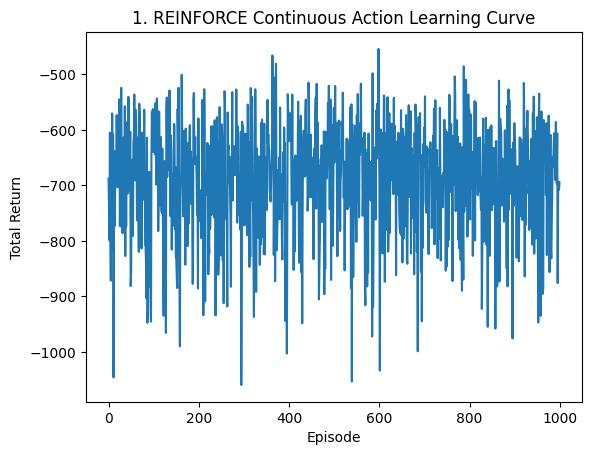

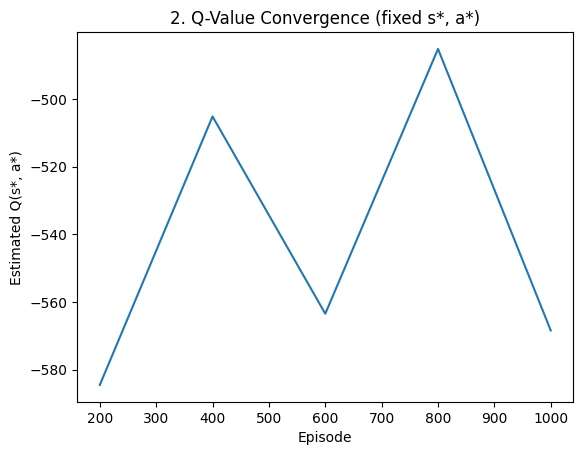

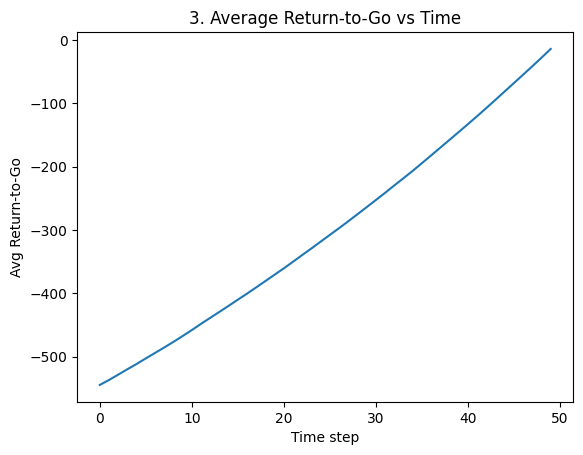

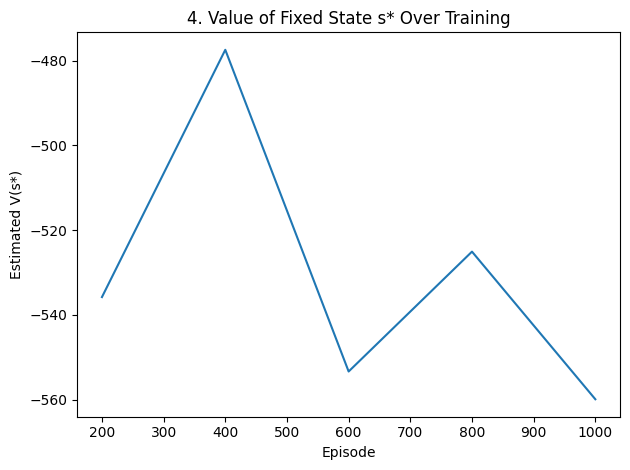